# EURLEX‑57K — Extraction, Exploration, and Cleaning

- **Data Extraction** (each split saved locally)
- **Data Exploration** on raw *train*
- **Data Cleaning** for *train*, *validation*, and *test*

In [1]:
!pip -q install datasets pandas pyarrow fastparquet unidecode tqdm matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 11.3 MB/s eta 0:00:00


## Step 1 — Imports

In [2]:
# Import core libraries
from pathlib import Path                # clean path handling
import re, random, numpy as np, pandas as pd
from datasets import load_dataset       # load EURLEX-57K from Hugging Face
from unidecode import unidecode         # normalize unicode accents (é -> e)
from tqdm import tqdm                   # progress bars (if/when needed)
import matplotlib.pyplot as plt         # plotting
import seaborn as sns                   # nicer plotting defaults

sns.set_theme()  # make plots a bit prettier


## Step 2 — Reproducibility seed

In [3]:
# Set a seed so any sampling later is repeatable
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
print("Seed set to:", SEED)

Seed set to: 42


## Step 3 — Dataset identifiers

In [4]:
# Define which dataset and which splits to use
DATASET  = "pietrolesci/eurlex-57k"   # Hugging Face dataset id
REVISION = None                       # set a commit hash here if you need a pinned snapshot
SPLITS   = ("train", "validation", "test")
print("Dataset:", DATASET, "| Splits:", SPLITS)

Dataset: pietrolesci/eurlex-57k | Splits: ('train', 'validation', 'test')


## Step 4 — Local folder for all files

In [5]:
BASE_DIR = Path("/content/data")
BASE_DIR.mkdir(parents=True, exist_ok=True)

print("Saving files under:", BASE_DIR)

Saving files under: /content/data


## Step 5 — Load EURLEX‑57K from Hugging Face

In [6]:
# Load all available splits. If REVISION is provided, HF fetches that exact commit.
if REVISION:
    ds = load_dataset(DATASET, revision=REVISION)
else:
    ds = load_dataset(DATASET)

print("Available splits:", list(ds.keys()))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-d708a5227a3690(…):   0%|          | 0.00/113M [00:00<?, ?B/s]

data/validation-00000-of-00001-0cd3337be(…):   0%|          | 0.00/14.8M [00:00<?, ?B/s]

data/test-00000-of-00001-b61a0b9731e7400(…):   0%|          | 0.00/14.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6000 [00:00<?, ? examples/s]

Available splits: ['train', 'validation', 'test']


## Step 6 — Save raw splits locally (unaltered)
### 6.1 Save **train** as Parquet

In [7]:
# Convert HF 'train' split to DataFrame and save as Parquet (compact, type-preserving)
df_train_raw = ds["train"].to_pandas()
raw_train_path = BASE_DIR / "train.parquet"
df_train_raw.to_parquet(raw_train_path, index=False)
print("Raw train saved:", raw_train_path, "| rows =", len(df_train_raw))

Raw train saved: /content/data/train.parquet | rows = 45000


### 6.2 Save **validation** as Parquet

In [8]:
df_val_raw = ds["validation"].to_pandas()
raw_val_path = BASE_DIR / "validation.parquet"
df_val_raw.to_parquet(raw_val_path, index=False)
print("Raw validation saved:", raw_val_path, "| rows =", len(df_val_raw))

Raw validation saved: /content/data/validation.parquet | rows = 6000


### 6.3 Save **test** as Parquet

In [9]:
df_test_raw = ds["test"].to_pandas()
raw_test_path = BASE_DIR / "test.parquet"
df_test_raw.to_parquet(raw_test_path, index=False)
print("Raw test saved:", raw_test_path, "| rows =", len(df_test_raw))

Raw test saved: /content/data/test.parquet | rows = 6000


## Step 7 — Quick exploration on raw **train**

### 7.1 Read the raw train file

In [10]:
# Read back the saved raw Parquet file so we explore the exact snapshot on disk
df_raw = pd.read_parquet(BASE_DIR / "train.parquet")
print("Rows:", len(df_raw))
print("Columns (first 12 shown):", list(df_raw.columns)[:12])

Rows: 45000
Columns (first 12 shown): ['celex_id', 'document_type', 'title', 'header', 'recitals', 'main_body', 'eurovoc_concepts', 'text', 'uid']


### 7.2 Ensure key columns exist (add if missing)

In [11]:
# Some fields may be absent in certain rows/versions; create them so downstream code is safe.
for col in ["document_type", "title", "header", "text", "eurovoc_concepts"]:
    if col not in df_raw.columns:
        df_raw[col] = None

df_raw[["document_type","title","header","text","eurovoc_concepts"]].head(3)

,document_type,title,header,text,eurovoc_concepts
0,Regulation,Commission Implementing Regulation (EU) No 727...,1.7.2014 EN Official Journal of the European U...,Commission Implementing Regulation (EU) No 727...,"[1402, 2771, 3191, 5055, 519, 5969, 5971]"
1,Regulation,Regulation (EEC) No 2481/75 of the Council of ...,REGULATION (EEC) No 2481/75 OF THE COUNCIL of...,Regulation (EEC) No 2481/75 of the Council of ...,"[2319, 2713, 2938, 693]"
2,Decision,"2010/8/EU, Euratom: Commission Decision of 22 ...",7.1.2010 EN Official Journal of the European U...,"2010/8/EU, Euratom: Commission Decision of 22 ...","[3560, 365, 4256, 4261, 4353, 4585]"


### 7.3 Document type counts

In [12]:
# Quick distribution of legal document types
doc_counts = df_raw["document_type"].value_counts().head(5)
print(doc_counts)

document_type
Regulation    29600
Decision      13627
Directive      1773
Name: count, dtype: int64


### 7.4 Null/empty rates for title/header/text

In [13]:
# Compute share of rows where each field is missing or blank
for c in ["title","header","text"]:
    rate = (df_raw[c].isna() | (df_raw[c].astype(str).str.strip()=="")).mean()
    print(f"empty {c}: {rate:.3f}")

empty title: 0.000
empty header: 0.000
empty text: 0.000


### 7.5 Text length distribution (words)

Percentiles: {0.5: 273.0, 0.9: 618.0999999999985, 0.99: 1519.020000000004}


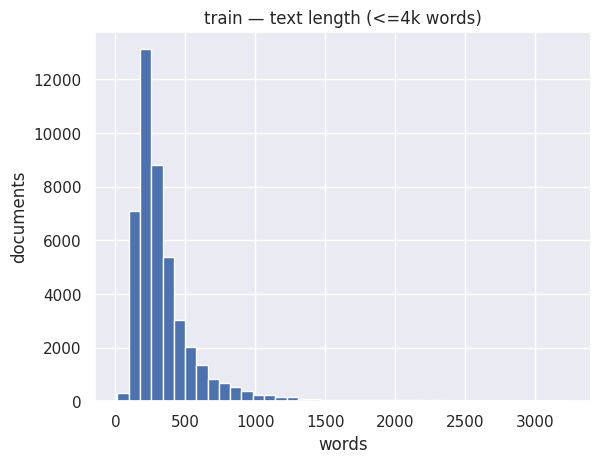

In [14]:
# Calculate per-row word counts to gauge typical document sizes
text_len = df_raw["text"].astype(str).str.split().apply(len)

# Show selected percentiles
print("Percentiles:", text_len.quantile([0.5,0.9,0.99]).to_dict())

# Plot histogram (clip right tail so the chart is readable)
plt.figure()
text_len.clip(0, 4000).hist(bins=40)
plt.title("train — text length (<=4k words)")
plt.xlabel("words"); plt.ylabel("documents")
plt.show()

## Step 8 — CLEAN **TRAIN**

### 8.1 Load raw train into a working DataFrame `df`

In [15]:
df = pd.read_parquet(BASE_DIR / "train.parquet").copy()
len(df)

45000

### 8.2 Ensure required columns exist

In [16]:
# If any expected column is missing, create it with a safe default (None)
required_cols = ["celex_id","uid","document_type","title","header","recitals","text","main_body","eurovoc_concepts"]
for c in required_cols:
    if c not in df.columns:
        df[c] = None
required_cols

['celex_id',
 'uid',
 'document_type',
 'title',
 'header',
 'recitals',
 'text',
 'main_body',
 'eurovoc_concepts']

### 8.3 Define a small `normalize()` text utility

In [17]:
# Inline function to normalize unicode/whitespace for text fields
def normalize(s):
    if s is None:
        return ""
    s = str(s).replace("\u00A0"," ")        # replace non-breaking spaces
    s = unidecode(s)                         # normalize accents (é -> e)
    s = re.sub(r"\s+"," ", s).strip()      # collapse extra spaces and trim
    return s

# Quick demo (should print 'resume')
print(normalize("résumé"))

resume


### 8.4 Normalize `title`

In [18]:
# Clean up the title text field
df["title"] = df["title"].apply(normalize)
df["title"].head(3)

,title
0,Commission Implementing Regulation (EU) No 727...
1,Regulation (EEC) No 2481/75 of the Council of ...
2,"2010/8/EU, Euratom: Commission Decision of 22 ..."


### 8.5 Normalize `header`

In [19]:
# Clean up the header text field
df["header"] = df["header"].apply(normalize)
df["header"].head(3)

,header
0,1.7.2014 EN Official Journal of the European U...
1,REGULATION (EEC) No 2481/75 OF THE COUNCIL of ...
2,7.1.2010 EN Official Journal of the European U...


### 8.6 Normalize `recitals`

In [20]:
# Clean up the recitals field (if missing, normalize returns empty string)
df["recitals"] = df["recitals"].apply(normalize)
df["recitals"].head(3)

,recitals
0,", Having regard to the Treaty on the Functioni..."
1,", Having regard to the Treaty establishing the..."
2,", Having regard to the Treaty on the Functioni..."


### 8.7 Normalize `text`

In [21]:
# Clean up the main text content
df["text"] = df["text"].apply(normalize)
df["text"].head(3)

,text
0,Commission Implementing Regulation (EU) No 727...
1,Regulation (EEC) No 2481/75 of the Council of ...
2,"2010/8/EU, Euratom: Commission Decision of 22 ..."


### 8.8 Define `as_list()` to force list type where needed

In [22]:
# Some fields may be NaN or scalar; we convert them to lists to keep schema consistent
def as_list(v):
    if isinstance(v,(list,tuple)):
        return list(v)
    if v is None or (isinstance(v,float) and pd.isna(v)):
        return []
    return [v]

# Quick demo (expect a list back)
as_list("foo"), as_list(["a","b"]), as_list(None)

(['foo'], ['a', 'b'], [])

### 8.9 Ensure `main_body` is a clean list of strings

In [23]:
# Normalize each element and drop empties
df["main_body"] = df["main_body"].apply(lambda v: [normalize(x) for x in as_list(v) if normalize(x)])
df["main_body"].head(3)

,main_body
0,"[[""A review of Implementing Regulation (EU) No..."
1,[['The first indent of Article 4 (1) of Regula...
2,[['The solution proposed by Austria concerning...


### 8.10 Ensure `eurovoc_concepts` is a unique, sorted list of strings

In [24]:
# Normalize each label, drop empties, make unique (+ sorted for stable downstream behavior)
df["eurovoc_concepts"] = df["eurovoc_concepts"].apply(
    lambda v: sorted({normalize(x) for x in as_list(v) if normalize(x)})
)
df["eurovoc_concepts"].head(3)

,eurovoc_concepts
0,[['1402' '2771' '3191' '5055' '519' '5969' '59...
1,[['2319' '2713' '2938' '693']]
2,[['3560' '365' '4256' '4261' '4353' '4585']]


### 8.11 Standardize `document_type` (allow only known values)

In [25]:
# Map anything outside the allowed set to 'Unknown' so the column is well-defined
ALLOWED_DOC_TYPES = {"Regulation","Decision","Directive"}
df["document_type"] = df["document_type"].apply(lambda x: x if str(x).strip() in ALLOWED_DOC_TYPES else "Unknown")
df["document_type"].value_counts()

,count
document_type,
Regulation,29600
Decision,13627
Directive,1773


### 8.12 Deduplicate rows (primary key: `celex_id`; fallback: `title||header`)

In [26]:
# Build a deduplication key per row
key_primary  = df["celex_id"].astype(str).str.strip()
key_fallback = df["title"].str.lower().str.strip() + "||" + df["header"].str.lower().str.strip()
dedupe_key   = key_primary.where(key_primary.astype(bool), key_fallback)

# Remove duplicate keys, keeping the first occurrence
before = len(df)
df = df.loc[~dedupe_key.duplicated()].reset_index(drop=True)
removed = before - len(df)
print("Duplicates removed:", removed, "| Remaining rows:", len(df))

Duplicates removed: 0 | Remaining rows: 45000


### 8.13 Derive `year` from `header`

In [27]:
# Extract a 4-digit year (19xx or 20xx) from the header and store as nullable Int64
df["year"] = df["header"].str.extract(r"\b((?:19|20)\d{2})\b").astype("float").astype("Int64")
df[["header","year"]].head(3)

,header,year
0,1.7.2014 EN Official Journal of the European U...,2014
1,REGULATION (EEC) No 2481/75 OF THE COUNCIL of ...,1975
2,7.1.2010 EN Official Journal of the European U...,2010


### 8.14 Derive `n_concepts` (count of EUROVOC labels)

In [28]:
# Count the number of labels attached to each document
df["n_concepts"] = df["eurovoc_concepts"].apply(len)
df["n_concepts"].describe()

,n_concepts
count,45000.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


### 8.15 Derive `text_len` (word count in `text`)

In [29]:
# Simple word count per document (split on whitespace)
df["text_len"] = df["text"].str.split().apply(len)
df["text_len"].describe()

,text_len
count,45000.000000
mean,351.191511
std,264.932162
min,15.000000
25%,202.000000
50%,273.000000
75%,399.000000
max,3236.000000


### 8.16 Drop rows with empty `text` (safety for modeling)

In [30]:
# Remove documents that ended up empty after normalization
before = len(df)
df = df[df["text_len"] > 0].reset_index(drop=True)
print("Dropped empty-text rows:", before - len(df), "| Remaining:", len(df))

Dropped empty-text rows: 0 | Remaining: 45000


In [32]:
# Save the cleaned training split as CSV so it's easy to reuse/inspect
train_csv = BASE_DIR / "train_cleaned.csv"
df.to_csv(train_csv, index=False)
print("Saved:", train_csv, "| rows =", len(df))

Saved: /content/data/train_cleaned.csv | rows = 45000


## Step 9 — CLEAN **VALIDATION**

### 9.1 Load raw validation into `df_v`

In [33]:
df_v = pd.read_parquet(BASE_DIR / "validation.parquet").copy()
len(df_v)

6000

### 9.2 Ensure required columns

In [34]:
for c in ["celex_id","uid","document_type","title","header","recitals","text","main_body","eurovoc_concepts"]:
    if c not in df_v.columns:
        df_v[c] = None
df_v.columns.tolist()[:12]

['celex_id',
 'document_type',
 'title',
 'header',
 'recitals',
 'main_body',
 'eurovoc_concepts',
 'text',
 'uid']

### 9.3 Normalize `title` / `header` / `recitals` / `text`

In [35]:
df_v["title"]    = df_v["title"].apply(normalize)
df_v["header"]   = df_v["header"].apply(normalize)
df_v["recitals"] = df_v["recitals"].apply(normalize)
df_v["text"]     = df_v["text"].apply(normalize)
df_v[["title","header","text"]].head(3)

,title,header,text
0,Council Regulation (EC) No 1400/1999 of 24 Jun...,COUNCIL REGULATION (EC) No 1400/1999 of 24 Jun...,Council Regulation (EC) No 1400/1999 of 24 Jun...
1,Commission Implementing Regulation (EU) No 381...,19.4.2011 EN Official Journal of the European ...,Commission Implementing Regulation (EU) No 381...
2,Council Joint Action 2007/732/CFSP of 13 Novem...,14.11.2007 EN Official Journal of the European...,Council Joint Action 2007/732/CFSP of 13 Novem...


### 9.4 Ensure list fields (`main_body`, `eurovoc_concepts`)

In [36]:
df_v["main_body"] = df_v["main_body"].apply(lambda v: [normalize(x) for x in as_list(v) if normalize(x)])
df_v["eurovoc_concepts"] = df_v["eurovoc_concepts"].apply(
    lambda v: sorted({normalize(x) for x in as_list(v) if normalize(x)})
)
df_v[["main_body","eurovoc_concepts"]].head(3)

,main_body,eurovoc_concepts
0,"[['For the 1999/2000 milk marketing year, the ...",[['1565' '2443' '2644' '2676' '4860']]
1,[['By way of derogation from points (a) and (b...,[['2173' '2733' '2972' '4314']]
2,[['Joint Action 2007/106/CFSP is hereby amende...,[['261' '3367' '5551' '5788' '5873']]


### 9.5 Standardize `document_type`

In [37]:
df_v["document_type"] = df_v["document_type"].apply(lambda x: x if str(x).strip() in ALLOWED_DOC_TYPES else "Unknown")
df_v["document_type"].value_counts()

,count
document_type,
Regulation,3964
Decision,1819
Directive,217


### 9.6 Deduplicate using `celex_id` (fallback: `title||header`)

In [38]:
key_primary  = df_v["celex_id"].astype(str).str.strip()
key_fallback  = df_v["title"].str.lower().str.strip() + "||" + df_v["header"].str.lower().str.strip()
dedupe_key    = key_primary.where(key_primary.astype(bool), key_fallback)
before = len(df_v)
df_v = df_v.loc[~dedupe_key.duplicated()].reset_index(drop=True)
print("Duplicates removed:", before - len(df_v), "| Remaining:", len(df_v))

Duplicates removed: 0 | Remaining: 6000


### 9.7 Derive `year`, `n_concepts`, `text_len`

In [39]:
df_v["year"] = df_v["header"].str.extract(r"\b((?:19|20)\d{2})\b").astype("float").astype("Int64")
df_v["n_concepts"] = df_v["eurovoc_concepts"].apply(len)
df_v["text_len"] = df_v["text"].str.split().apply(len)
df_v[["year","n_concepts","text_len"]].describe(include="all")

,year,n_concepts,text_len
count,5998.0,6000.0,6000.000000
mean,1999.456319,1.0,344.020167
std,13.660441,0.0,257.362015
min,1900.0,1.0,49.000000
25%,1992.0,1.0,200.000000
50%,2001.0,1.0,268.000000
75%,2007.0,1.0,395.000000
max,2098.0,1.0,2431.000000


### 9.8 Drop rows with empty `text`

In [40]:
before = len(df_v)
df_v = df_v[df_v["text_len"] > 0].reset_index(drop=True)
print("Dropped:", before - len(df_v), "| Remaining:", len(df_v))

Dropped: 0 | Remaining: 6000


### 9.9 Save **validation_cleaned.csv**

In [41]:
val_csv = BASE_DIR / "validation_cleaned.csv"
df_v.to_csv(val_csv, index=False)
print("Saved:", val_csv, "| rows =", len(df_v))

Saved: /content/data/validation_cleaned.csv | rows = 6000


## Step 10 — CLEAN **TEST**

### 10.1 Load raw test into `df_t`

In [42]:
df_t = pd.read_parquet(BASE_DIR / "test.parquet").copy()
len(df_t)

6000

### 10.2 Ensure required columns

In [43]:
for c in ["celex_id","uid","document_type","title","header","recitals","text","main_body","eurovoc_concepts"]:
    if c not in df_t.columns:
        df_t[c] = None
df_t.columns.tolist()[:12]

['celex_id',
 'document_type',
 'title',
 'header',
 'recitals',
 'main_body',
 'eurovoc_concepts',
 'text',
 'uid']

### 10.3 Normalize `title` / `header` / `recitals` / `text`

In [44]:
df_t["title"]    = df_t["title"].apply(normalize)
df_t["header"]   = df_t["header"].apply(normalize)
df_t["recitals"] = df_t["recitals"].apply(normalize)
df_t["text"]     = df_t["text"].apply(normalize)
df_t[["title","header","text"]].head(3)

,title,header,text
0,Commission Implementing Decision of 14 October...,15.10.2011 EN Official Journal of the European...,Commission Implementing Decision of 14 October...
1,Commission Regulation (EC) No 2052/96 of 25 Oc...,COMMISSION REGULATION (EC) No 2052/96 of 25 Oc...,Commission Regulation (EC) No 2052/96 of 25 Oc...
2,Commission Regulation (EC) No 1868/2001 of 24 ...,Commission Regulation (EC) No 1868/2001 of 24 ...,Commission Regulation (EC) No 1868/2001 of 24 ...


### 10.4 Ensure list fields (`main_body`, `eurovoc_concepts`)

In [45]:
df_t["main_body"] = df_t["main_body"].apply(lambda v: [normalize(x) for x in as_list(v) if normalize(x)])
df_t["eurovoc_concepts"] = df_t["eurovoc_concepts"].apply(
    lambda v: sorted({normalize(x) for x in as_list(v) if normalize(x)})
)
df_t[["main_body","eurovoc_concepts"]].head(3)

,main_body,eurovoc_concepts
0,[['The Annex to Decision 2011/163/EU is replac...,[['1166' '1338' '1445' '1644' '1729' '1841' '1...
1,[['The provisional quantity to be allocated to...,[['1120' '1309' '161' '2957']]
2,[['1. Applications for import licences for the...,[['1474' '1644' '2738' '4692' '5898']]


### 10.5 Standardize `document_type`

In [46]:
df_t["document_type"] = df_t["document_type"].apply(lambda x: x if str(x).strip() in ALLOWED_DOC_TYPES else "Unknown")
df_t["document_type"].value_counts()

,count
document_type,
Regulation,3967
Decision,1793
Directive,240


### 10.6 Deduplicate using `celex_id` (fallback: `title||header`)

In [47]:
key_primary  = df_t["celex_id"].astype(str).str.strip()
key_fallback  = df_t["title"].str.lower().str.strip() + "||" + df_t["header"].str.lower().str.strip()
dedupe_key    = key_primary.where(key_primary.astype(bool), key_fallback)
before = len(df_t)
df_t = df_t.loc[~dedupe_key.duplicated()].reset_index(drop=True)
print("Duplicates removed:", before - len(df_t), "| Remaining:", len(df_t))

Duplicates removed: 0 | Remaining: 6000


### 10.7 Derive `year`, `n_concepts`, `text_len`

In [48]:
df_t["year"] = df_t["header"].str.extract(r"\b((?:19|20)\d{2})\b").astype("float").astype("Int64")
df_t["n_concepts"] = df_t["eurovoc_concepts"].apply(len)
df_t["text_len"] = df_t["text"].str.split().apply(len)
df_t[["year","n_concepts","text_len"]].describe(include="all")

,year,n_concepts,text_len
count,5997.0,6000.0,6000.000000
mean,1999.842755,1.0,350.362667
std,13.975049,0.0,264.543140
min,1900.0,1.0,43.000000
25%,1993.0,1.0,202.000000
50%,2002.0,1.0,274.000000
75%,2007.0,1.0,395.000000
max,2099.0,1.0,2443.000000


### 10.8 Drop rows with empty `text`

In [49]:
before = len(df_t)
df_t = df_t[df_t["text_len"] > 0].reset_index(drop=True)
print("Dropped:", before - len(df_t), "| Remaining:", len(df_t))

Dropped: 0 | Remaining: 6000


### 10.9 Save **test_cleaned.csv**

In [50]:
test_csv = BASE_DIR / "test_cleaned.csv"
df_t.to_csv(test_csv, index=False)
print("Saved:", test_csv, "| rows =", len(df_t))

Saved: /content/data/test_cleaned.csv | rows = 6000


# **Insight 1 — Distribution of document types**

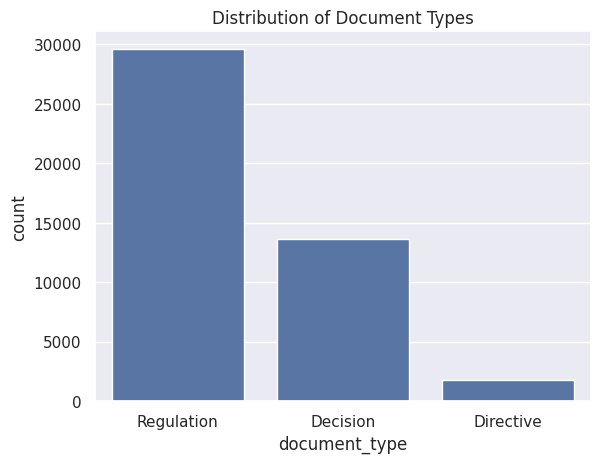

In [51]:
sns.countplot(x='document_type', data=df)
plt.title("Distribution of Document Types")
plt.show()

**Observation:** Regulations dominate the dataset, followed by Decisions; Directives are least frequent.

# **Insight 2 — Number of documents per year**

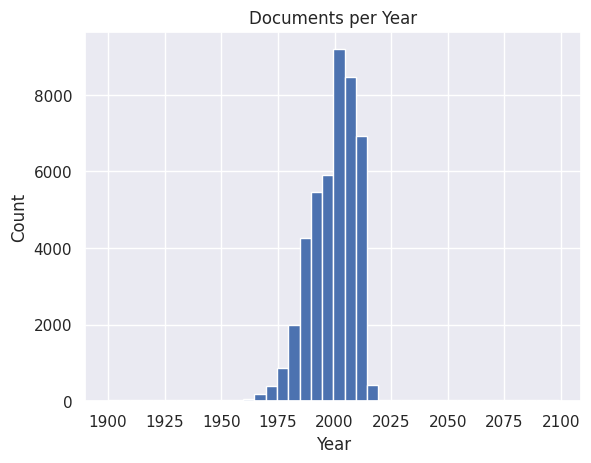

In [52]:
df['year'].dropna().astype(int).hist(bins=40)
plt.title("Documents per Year")
plt.xlabel("Year"); plt.ylabel("Count")
plt.show()

**Observation:** The majority of documents are from 1980 onwards, peaking in the 1990s and 2000s.

# **Insight 3 — Distribution of text lengths**

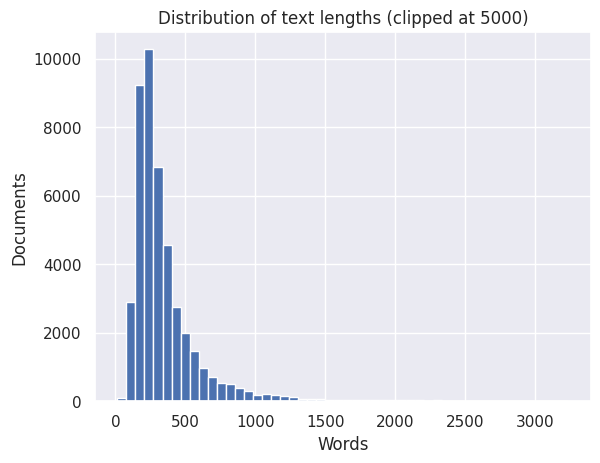

In [53]:
df['text_len'].clip(0,5000).hist(bins=50)
plt.title("Distribution of text lengths (clipped at 5000)")
plt.xlabel("Words"); plt.ylabel("Documents")
plt.show()

**Observation:** Most documents are under 2000 words, but a few are very long, creating a heavy right tail.

# **Insight 4 — Average text length by document type**

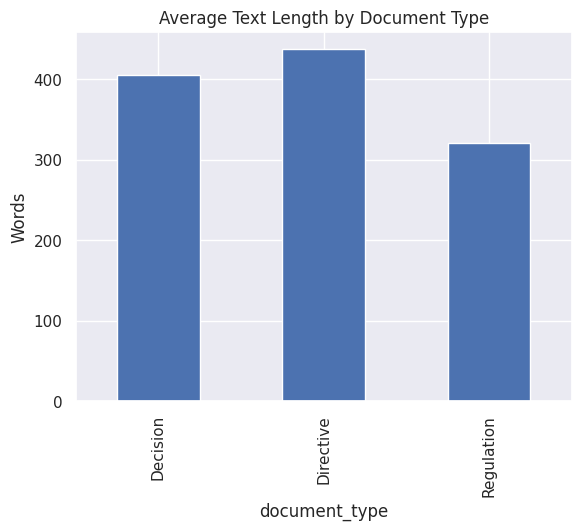

In [54]:
df.groupby('document_type')['text_len'].mean().plot(kind='bar')
plt.title("Average Text Length by Document Type")
plt.ylabel("Words")
plt.show()

**Observation:** Regulations tend to be longer than Decisions and Directives.

# **Insight 5 — Average text length trend over years**

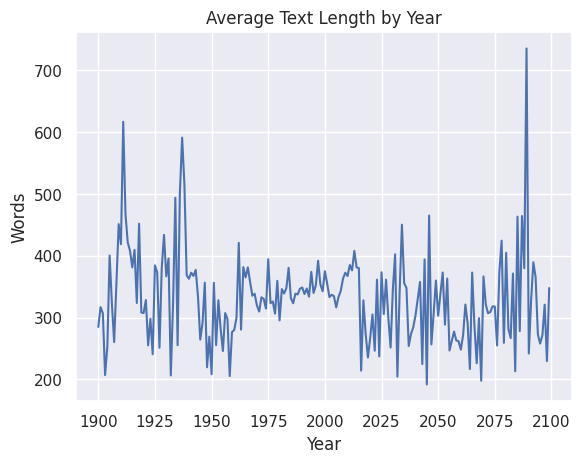

In [55]:
df.groupby('year')['text_len'].mean().plot()
plt.title("Average Text Length by Year")
plt.xlabel("Year"); plt.ylabel("Words")
plt.show()

**Observation:** Average text length has generally increased over time, suggesting more detailed documents in recent decades.

# **Insight 6 — Top 10 Repeated Titles**

/tmp/ipython-input-988128469.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


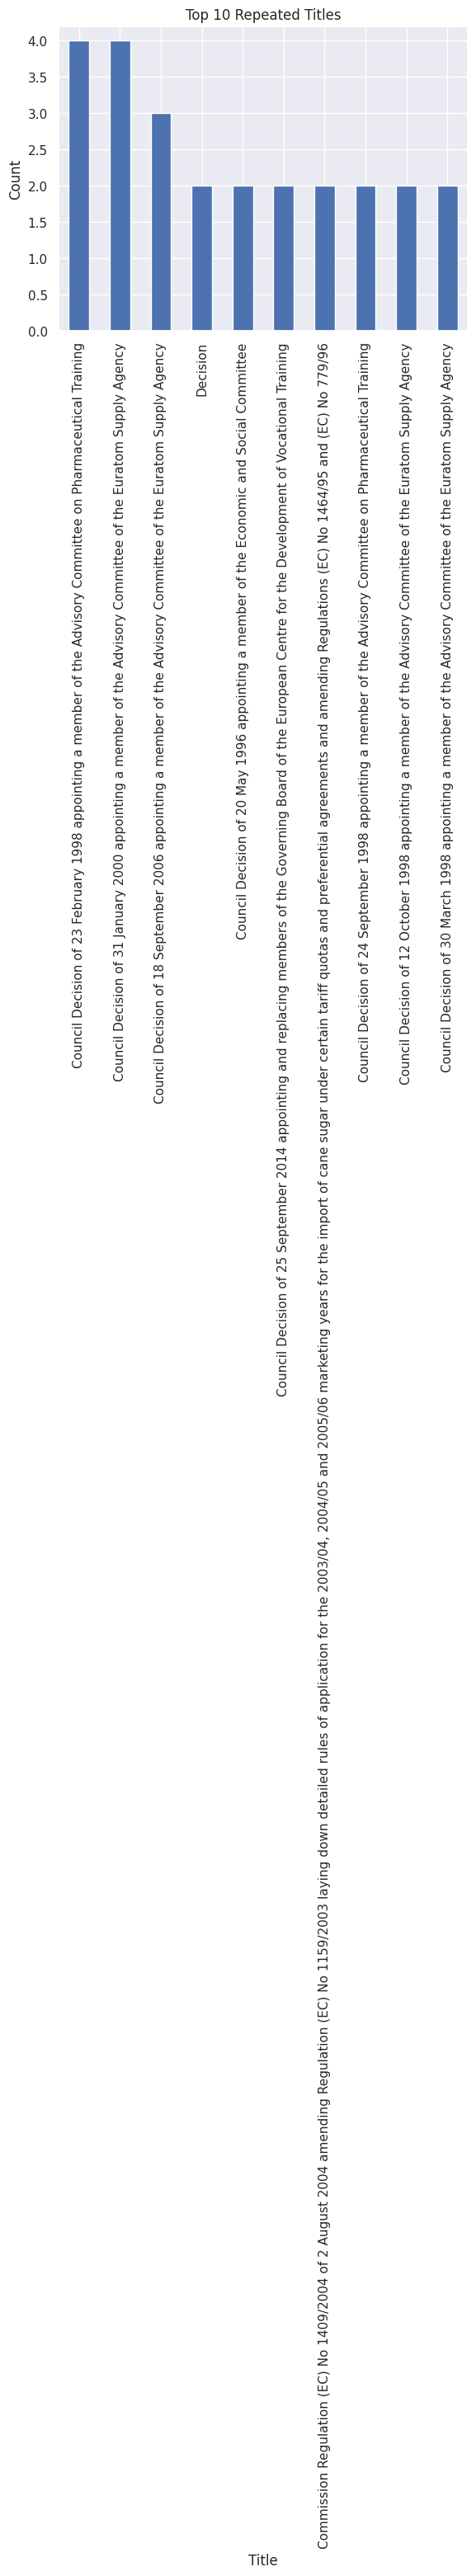

In [58]:
# Count repeated titles (after basic normalization/stripping)
title_counts = dfq['title'].astype(str).str.strip().value_counts().head(10)

plt.figure()
title_counts.plot(kind='bar')
plt.title("Top 10 Repeated Titles")
plt.xlabel("Title"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

**Observation:** A handful of titles appear very frequently, indicating **boilerplate** or template usage. This may cause **data leakage** or bias if duplicates span across splits.

# **Insight 7 — Average Number of Concepts by Document Type**

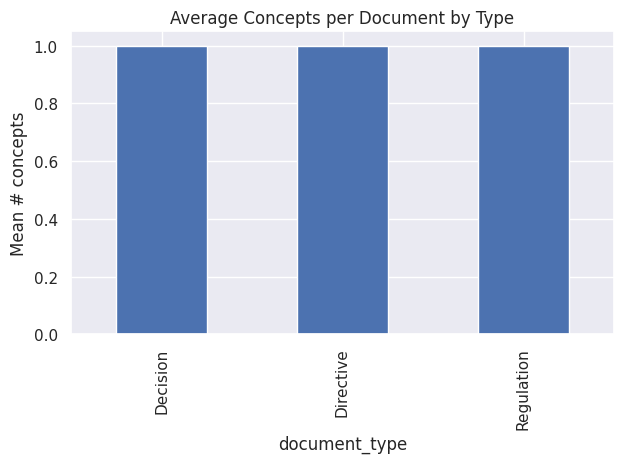

In [59]:
# Compute mean label cardinality per document type
means = dfq.groupby('document_type')['n_concepts'].mean()

plt.figure()
means.plot(kind='bar')
plt.title("Average Concepts per Document by Type")
plt.xlabel("document_type"); plt.ylabel("Mean # concepts")
plt.tight_layout(); plt.show()

**Observation:** Some document types receive **richer annotations** (more concepts on average). Consider **stratified evaluation** or **type‑specific thresholds** in multi‑label models.

# **Insight 8 — Share of Text-Length Outliers by Document Type**

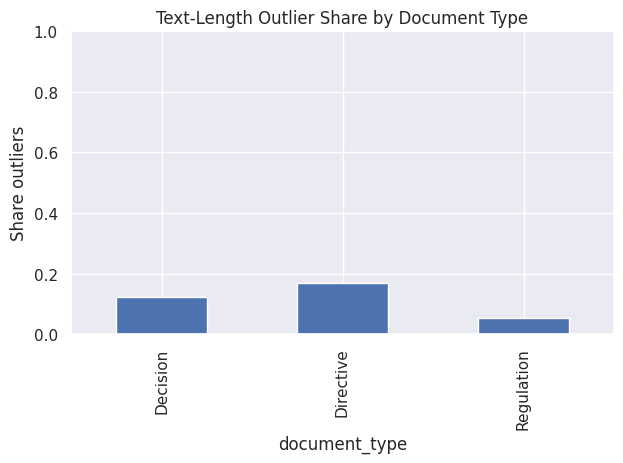

In [60]:
# Flag outliers using the IQR rule (recompute here for robustness)
def iqr_flags(series):
    q1 = series.quantile(0.25); q3 = series.quantile(0.75)
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    return (series < lo) | (series > hi)

if 'text_len_outlier' not in dfq.columns:
    dfq['text_len_outlier'] = iqr_flags(dfq['text_len'])

share = dfq.groupby('document_type')['text_len_outlier'].mean()

plt.figure()
share.plot(kind='bar')
plt.title("Text-Length Outlier Share by Document Type")
plt.xlabel("document_type"); plt.ylabel("Share outliers")
plt.ylim(0, 1)
plt.tight_layout(); plt.show()

**Observation:** **Regulations** typically contribute a **higher fraction of extreme-length** documents. Plan **type‑aware truncation** or **chunking** policies to control memory/latency.

# **Insight 9 — Label Imbalance: Top 20 EUROVOC Concepts**

/tmp/ipython-input-123684913.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


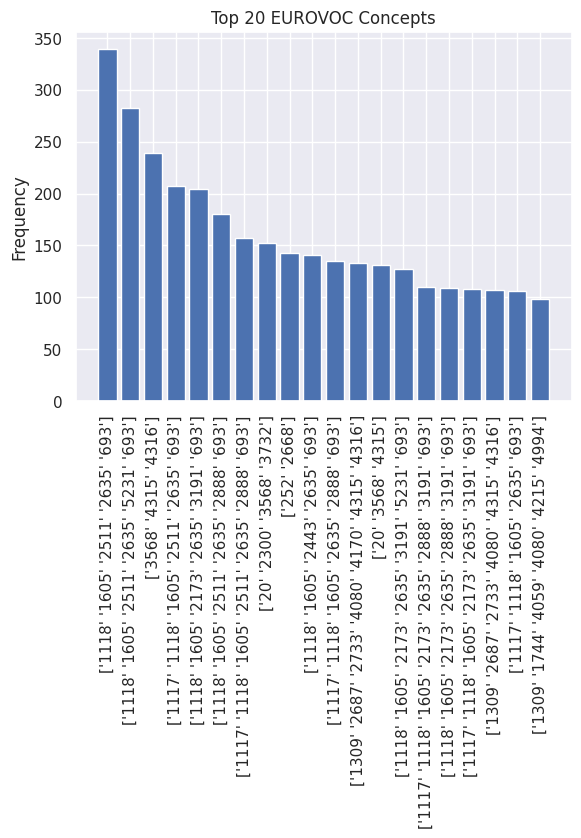

In [61]:
# 'eurovoc_concepts' is stored as a stringified list in CSV; parse safely
def parse_labels(cell):
    if isinstance(cell, list): return cell
    if isinstance(cell, str):
        try:
            val = ast.literal_eval(cell)
            return val if isinstance(val, list) else []
        except Exception:
            return []
    return []

all_labels = []
for cell in dfq['eurovoc_concepts']:
    labs = parse_labels(cell)
    all_labels.extend([str(x) for x in labs if str(x)])

# Count top 20
from collections import Counter
top20 = Counter(all_labels).most_common(20)
labels = [w for w,_ in top20]; counts = [c for _,c in top20]

plt.figure()
plt.bar(labels, counts)
plt.title("Top 20 EUROVOC Concepts")
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.tight_layout(); plt.show()

**Observation:** A small set of concepts dominate, while many are rare — classic **long‑tail** imbalance. Use **class weighting**, **threshold tuning**, or **focal loss** strategies for multi‑label learning.

# **Insight 10 — Vocabulary Size vs Document Count (Token Diversity)**

Unique tokens in sample: 10733


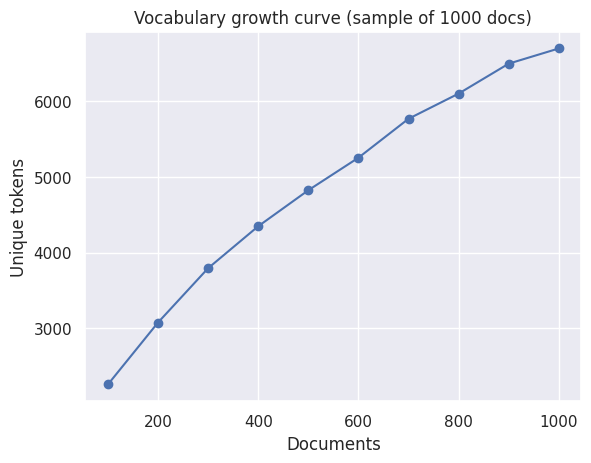

In [63]:
sample = dfq["text"].astype(str).sample(min(3000, len(dfq)), random_state=SEED)
vocab = set()
for doc in sample:
    for tok in doc.lower().split():
        if tok.isalpha():
            vocab.add(tok)

print("Unique tokens in sample:", len(vocab))

# Growth curve: how vocabulary size increases with more documents
sizes = []
seen = set()
for i, doc in enumerate(sample[:1000]):  # first 1000 docs
    for tok in doc.lower().split():
        if tok.isalpha():
            seen.add(tok)
    if (i+1) % 100 == 0:
        sizes.append(len(seen))

plt.figure()
plt.plot(range(100,1001,100), sizes, marker="o")
plt.title("Vocabulary growth curve (sample of 1000 docs)")
plt.xlabel("Documents"); plt.ylabel("Unique tokens")
plt.show()



Observation: The vocabulary grows steadily as more documents are added, showing high lexical diversity. For modeling, this implies tokenization choices (subword models like BPE or SentencePiece) are essential to handle the large vocabulary without exploding embedding size.